In [143]:
import numpy as np
import random
import causaldag as cd
import matplotlib.pyplot as plt
from scipy.stats import t, norm, bernoulli
from sklearn import metrics

from dag_conditioning import *
from causal_tensor import *

In [194]:
np.random.seed(123)
random.seed(123)

dag = cd.DAG(arcs={(0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (2,4), (3,4), (3,5), (4,6)})
gdag = cd.rand.rand_weights(dag)

setting = {'C': [0,2,5,6], 'A': [0, 1, 3], 'X': [4]}

In [329]:
def t_stat(X, i, j, i0 = 0, j0 = 0):
    m = X.shape[0]
    n = X.shape[1]
    size = X.shape[2]
    
    #Eq = np.mean(X[i0,j0], axis=0) + np.mean(X[i,j], axis=0) - np.mean(X[i,j0], axis=0) - np.mean(X[i0,j], axis=0)
       
    Dj = np.mean(X[i,j], axis=0) - np.mean(X[i0,j], axis=0)
    D0 = np.mean(X[i,j0], axis=0) - np.mean(X[i0,j0], axis=0)

    Eq = Dj - D0
    
    S2j = (np.var(X[i,j], axis=0, ddof=1) + np.var(X[i0,j], axis=0, ddof=1))/2
    S20 = (np.var(X[i,j0], axis=0, ddof=1) + np.var(X[i0,j0], axis=0, ddof=1))/2
    
    T = Eq/np.sqrt(2*(S2j + S20)/size)
    
    df = (S2j/size + S20/size)**2/((S2j**2 + S20**2)/(size**2*(size-1)))
    
    return T, df

In [330]:
def statistic_matrix(X, pivot = "previous"):
    m = X.shape[0]
    n = X.shape[1]
    size = X.shape[2]
    
    #df = 4*(size-1)
        
    i0,j0 = 0,0
    
    Ts = []
    dfs = []
    pvals = []
    for i in range(1,m):
        for j in range(1,n):
            if pivot == "previous": i0,j0 = i-1,j-1
                
            T, df = t_stat(X, i, j, i0, j0)
            Ts.append(T)
            dfs.append(df)
            pvals.append(2*t.cdf(-np.abs(T), df))
    
    return Ts, dfs, pvals

In [331]:
def causal_tensor_SI(m, n, gdag, setting: dict[str, list], size = 1, noisy = True):
    p = len(setting['X'])
    #q = len(setting['A'])
    r = len(setting['C'])
    
    #A = 10*np.random.rand(m, q)
    A = 10*np.random.rand(m, gdag.nnodes)
    C = 10*np.random.rand(n, r)
    
    X = np.zeros((m, n, size, p))

    for i, a in enumerate(A):
        setting['A'] = []
        for idx, b in enumerate(bernoulli.rvs(0.2, size = gdag.nnodes)):
            if b == 1: setting['A'].append(idx)
                
        q = len(setting['A'])
        
        interventions = {}
        for idx in range(q): interventions.update({setting['A'][idx]: a[idx]})
        
        for j, c in enumerate(C):
            conditions = {}
            for idx in range(r): conditions.update({setting['C'][idx]: c[idx]})

            # we get "size" samples and then take the average
            X[i,j] = sample_condition_intervention(gdag, conditions, interventions, size, noisy)[:,setting['X']]
        
    X = X.squeeze()  # matrix case or size = 1
    return X

In [332]:
n_samples = 200
size = 4
m = 5
n = 5

# FE behavior

In [297]:
Ts = []
gt = [] # ground truth

In [302]:
for _ in range(n_samples):
    X = causal_tensor(m, n, gdag, setting, size = size, noisy = True)
    T, dfs, pvals = statistic_matrix(X)
    Ts.append(np.max(np.abs(T)))
    gt.append(1)

In [304]:
pvals

[0.5863909406547732,
 0.8933846018935899,
 0.39012027617920775,
 0.9303575440381909,
 0.7242162344216094,
 0.9756771995282592,
 0.7203421464357911,
 0.5370067543207091,
 0.07399455071848893,
 0.7270068599446204,
 0.3609377706772179,
 0.5269814803872451,
 0.2680421508263259,
 0.6841023594255544,
 0.5954697430222223,
 0.694820475577925]

# SI behavior

In [223]:
for _ in range(n_samples):
    X = causal_tensor_SI(m, n, gdag, setting, size = size, noisy = True)
    T, dfs, pvals = statistic_matrix(X)
    Ts.append(np.max(np.abs(T)))
    gt.append(0)

# p-values and ROC curve

In [224]:
#pvals = 2*t.cdf(-np.array(Ts), df) # df changes
#pvals

In [225]:
fpr, tpr, thrs = metrics.roc_curve(gt, pvals)

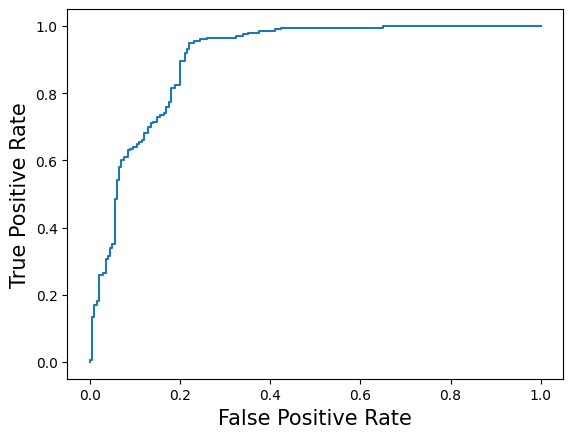

In [226]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
#plt.title('ROC curve', fontsize = 17)
plt.show()

In [305]:
def ROC(m, n, size, nsamples = 200, gdag = gdag):
    pvals = []
    gt = [] # ground truth
    
    #setting = dict()
    setting = {'C': [0,2,5,6], 'A': [0, 1, 3], 'X': [4]}
    
    for _ in range(n_samples):
        
        setting['A'] = []
        for idx, b in enumerate(bernoulli.rvs(0.2, size = gdag.nnodes)):
            if b == 1: setting['A'].append(idx)
                
        """
        setting['C'] = []
        for idx, b in enumerate(bernoulli.rvs(0.6, size = gdag.nnodes)):
            if b == 1: setting['C'].append(idx)
                
        if len(setting['C']) == gdag.nnodes:
            setting['C'].pop(random.randrange(len(setting['C'])))
        elif len(setting['C']) == 0:
            setting['C'] = [random.randint(0,gdag.nnodes-1)]
                
        setting['X'] = [random.randint(4,gdag.nnodes-1)]
        """
        #true
        X = causal_tensor(m, n, gdag, setting, size = size, noisy = True)
        T, dfs, pval = statistic_matrix(X)
        pvals.append(np.min(pval))
        gt.append(1)
    
        #false
        X = causal_tensor_SI(m, n, gdag, setting, size = size, noisy = True)
        T, dfs, pval = statistic_matrix(X)
        pvals.append(np.min(pval))
        gt.append(0)
    
    fpr, tpr, thrs = metrics.roc_curve(gt, pvals)
    return fpr, tpr, thrs

2 2
2 5
2 10
5 2
5 5
5 10
10 2
10 5
10 10


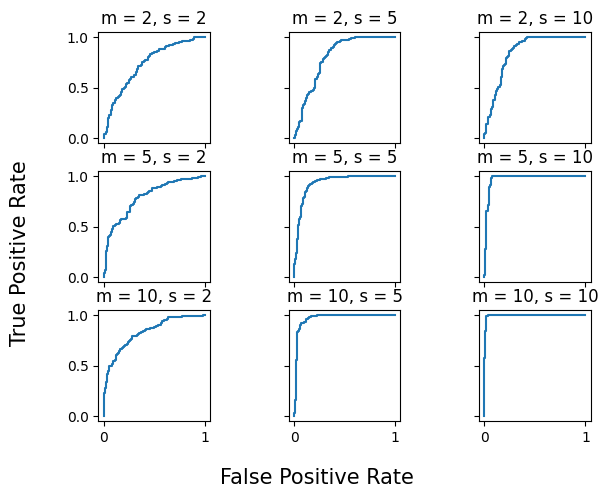

In [333]:
ms = [2,5,10]
sizes = [2,5,10]

fig, axs = plt.subplots(len(ms), len(sizes), sharex=True, sharey=True)
fig.supylabel('True Positive Rate', fontsize=15)
fig.supxlabel('False Positive Rate', fontsize=15)
fig.tight_layout(pad=1.0)

for i, m in enumerate(ms):
    for j, size in enumerate(sizes):
        
        print(m,size)
        
        fpr, tpr, thrs = ROC(m, n, size)
    
        axs[i,j].plot(fpr,tpr)
        axs[i,j].title.set_text('m = ' + str(m) + ', s = ' + str(size))
        
        axs[i,j].set_box_aspect(1)


plt.show()

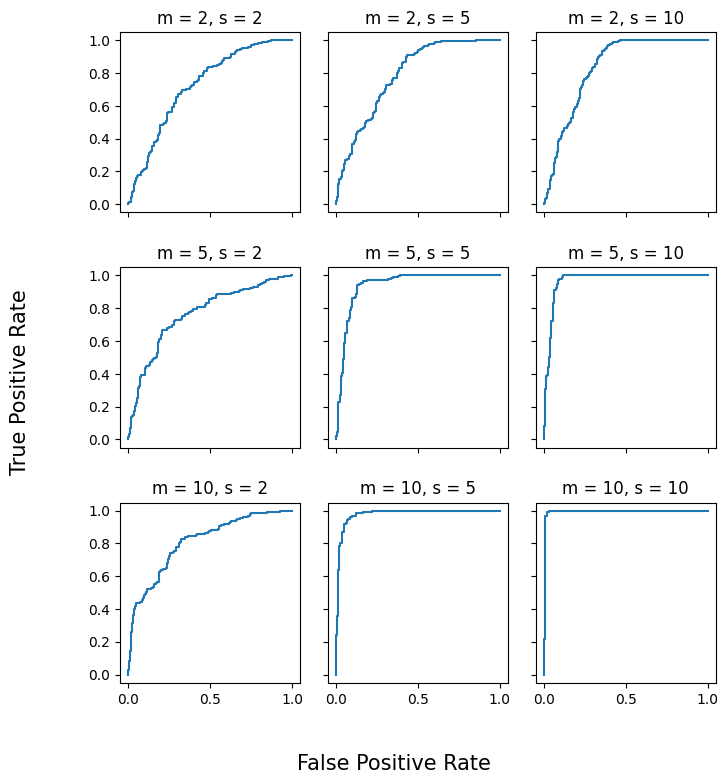

In [328]:

fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout(pad=2)
fig